# Bagging

Vamos a utilizar el siguiente dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Las siguientes celdas lo descargan e importan:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1X0MT5YFVOduVogJ9cZKjCJ7fs-OdVuAT' -O weatherAUS.csv

'https://docs.google.com/uc?export=download: Scheme missing.
"id" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [5]:
df = pd.read_csv("E:\Mis Carpetas\Documentos\Data Science/weather.csv")

In [6]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Vamos a descartar las columnas:

- Sunshine          
- Evaporation       
- Cloud3pm          
- Cloud9am  
- Location
- Date       
- WindGustDir
- WindDir9am 

In [7]:
df.drop(columns=["Sunshine","Evaporation","Cloud3pm","Cloud9am","Location","Date","WindGustDir","WindDir9am"],axis=1,inplace=True)

In [8]:
df.shape

(145460, 15)

Descartar todas las filas que tengan nulos:

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(119016, 15)

In [15]:
df.head(5)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


Separamos en X e y. Nuestro objetivo es predecir si va a llover mañana.

In [32]:
X = df.drop("RainTomorrow", axis=1).copy()
y = df.RainTomorrow.copy()

Aplicamos train test split. El set de test tendrá un 20% de los datos con un random state de 42 y stratify.

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Aplicar one hot encoder a las variables categóricas.

Recuerden hacer fit en train y luego en test solo transform.

In [92]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
enc.fit(X_train[["WindDir3pm", "RainToday"]])

encoded = enc.transform(X_train[["WindDir3pm", "RainToday"]])
df_encoded = pd.DataFrame(columns=enc.get_feature_names(), data= encoded, index=X_train.index)

X_train = pd.concat([X_train, df_encoded],axis=1)


encoded = enc.transform(X_test[["WindDir3pm", "RainToday"]])
df_encoded = pd.DataFrame(columns=enc.get_feature_names(), data= encoded, index=X_test.index)

X_test = pd.concat([X_test, df_encoded], axis=1)

Dropear las columnas originales:

In [93]:
X_train.drop(columns=["WindDir3pm", "RainToday"],axis=1, inplace=True)
X_test.drop(columns=["WindDir3pm", "RainToday"],axis=1, inplace=True)

Llevar el target a una variable numérica:

- 1 si va a llover mañana
- 0 si no va a llover mañana

In [94]:
y_train = y_train.map({'Yes':1,'No':0})
y_test = y_test.map({'Yes':1, 'No':0})

Entrenar un arbol de decision con:
- max_depth=10
- random_state=0

y obtener el classification report para train y test.

In [102]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=10, random_state=0).fit(X_train,y_train)


y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     74409
           1       0.79      0.56      0.65     20803

    accuracy                           0.87     95212
   macro avg       0.84      0.76      0.79     95212
weighted avg       0.86      0.87      0.86     95212

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     18603
           1       0.70      0.49      0.58      5201

    accuracy                           0.84     23804
   macro avg       0.78      0.72      0.74     23804
weighted avg       0.83      0.84      0.83     23804



Ahora, usar un Bagging Classifier armado con árboles de decisión: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Los árboles que usemos en este clasificador, deberán tener la misma profundidad máxima (max_depth) que el árbol que entrenamos recién.

Además usar: 

- n_estimators = 200
- n_jobs = -1 -> ¿Qué pasa si sacamos esto?
- random_state = 0 -> En el arbol y en el BaggingClassifier

In [103]:
%%time
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, random_state=0), n_estimators=200,n_jobs=-1,random_state=0)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred =  clf.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     74409
           1       0.85      0.56      0.67     20803

    accuracy                           0.88     95212
   macro avg       0.87      0.76      0.80     95212
weighted avg       0.88      0.88      0.87     95212

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     18603
           1       0.76      0.50      0.60      5201

    accuracy                           0.86     23804
   macro avg       0.82      0.73      0.76     23804
weighted avg       0.85      0.86      0.85     23804

Wall time: 3min 26s


Ahora, probar con un RandomForestClassifier. 

Los hiperparámetros serán igual que los anteriores:

- max_depth=10
- n_estimators=200
- n_jobs=-1
- random_state=0

In [105]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators = 200, n_jobs = -1, random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     74409
           1       0.84      0.49      0.62     20803

    accuracy                           0.87     95212
   macro avg       0.85      0.73      0.77     95212
weighted avg       0.86      0.87      0.85     95212

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     18603
           1       0.78      0.46      0.58      5201

    accuracy                           0.85     23804
   macro avg       0.82      0.71      0.74     23804
weighted avg       0.85      0.85      0.84     23804

Wall time: 10.3 s


Ahora, en el random forest, imprimir la importancia de las features:

In [106]:
clf.feature_importances_

array([0.02881054, 0.02850598, 0.09102755, 0.06873099, 0.01320222,
       0.01649553, 0.0752408 , 0.36632465, 0.05386588, 0.07170833,
       0.02159009, 0.04216529, 0.00063554, 0.00066353, 0.00059856,
       0.00303354, 0.00157787, 0.00178885, 0.00224139, 0.0018103 ,
       0.00123713, 0.00080913, 0.00097969, 0.00115743, 0.00114065,
       0.00120665, 0.00156089, 0.00092983, 0.04669038, 0.0542708 ])

Correr el siguiente código para obtener sus feature importances:

In [107]:
fi = pd.DataFrame(columns=["FEATURE", "IMPORTANCE"])
fi["FEATURE"] = X_train.columns
fi["IMPORTANCE"] = clf.feature_importances_
fi = fi.sort_values("IMPORTANCE", ascending=False)

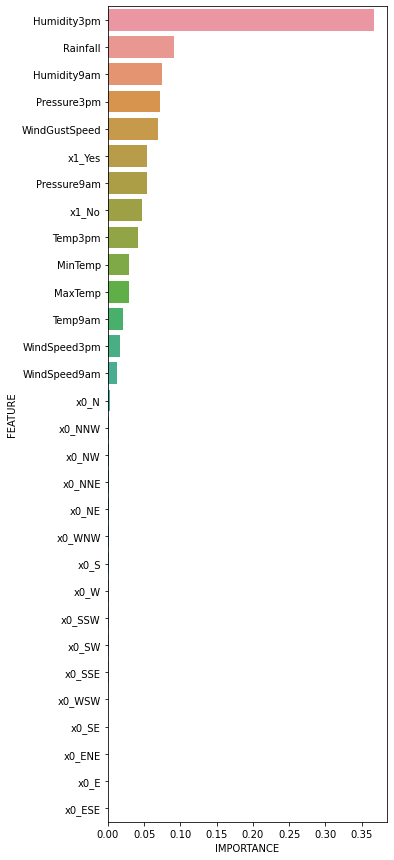

In [108]:
plt.figure(figsize=(5, 15))
sns.barplot(y=fi.FEATURE, x=fi.IMPORTANCE)
plt.show()

Ahora, aplicar random forest en su proyecto del primer sprint.

Buscar los mejores hiperparámetros con grid search y finalmente imprimir el feature importance de las variables que utilizaron para entrenar.